<a href="https://colab.research.google.com/github/divadde/computer_vision_project/blob/main/progetto_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparazione del dataset


Come primo passo, importo tutte le librerie che sono necessarie per la realizzazione del task di segmentazione e object detection. In particolare importo quelle librerie che possono essermi utili in fase di preparazione del dataset.

In [ ]:
import torch
import torchvision
import os
import numpy as np
from google.colab import drive
from collections import defaultdict
import json
import pycocotools
from pycocotools import mask
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat, Mask
from torchvision.transforms.v2 import ConvertBoundingBoxFormat

Scrivo una funzione ausiliaria *buildDataset* che verrà utilizzata all'interno del dataset custom per l'estrazione e la creazione delle labels in un formato adatto al training del modello. Si può osservare dal file json delle etichette, che il formato delle box è del tipo XYWH, per l'addestramento del modello è richiesto che il formato sia del tipo XYXY. Per raggiungere tale scopo verrà usato il convertitore messo a disposizione da torchvision. Inoltre si è notato che all'interno del training set, sono presenti delle box degenerate (ovvero quando ampiezza o altezza sono pari a 0), per questa ragione viene effettuato un controllo e se viene riscontrata una box degenerata, viene incrementato di un delta (=0.1) l'ampiezza o l'altezza degenere. Il modello che verrà usato in seguito, utilizza per convenzione una classe di "background" che ha id pari a 0; per questo motivo si andrà a incrementare di 1 ogni "category_id" degli oggetti rilevati nell'immagine.



In [ ]:
def buildDataset(json_file):
  #raggruppo le label per ogni immagine
  data = json_file['annotations']
  grouped_data = defaultdict(list)

  [grouped_data[k['image_id']].append(k) for k in data]

  grouped_dict = dict(grouped_data)

  result_dict = {}
  for image in grouped_dict.values():
    image_id = image[0]['image_id']
    boundy_boxes = []
    segm_masks = []
    classes = []
    for obj in image:
      segm_masks.append(mask.decode(mask.merge(mask.frPyObjects(obj['segmentation'],700,700))))
      b = obj['bbox']
      #print(b)
      #controllo se ci sono boxes degenerate
      delta=0.1
      if b[2]==0: b[2]=b[2]+delta
      if b[3]==0: b[3]=b[3]+delta
      box = [b[0],b[1],b[2],b[3]] #formato XYWH
      boundy_boxes.append(box)
      classes.append(obj['category_id']+1) #la prima classe non deve avere id 0.
    boundy_boxes = torchvision.tv_tensors.BoundingBoxes(data=np.array(boundy_boxes),format = BoundingBoxFormat.XYWH, canvas_size=(700, 700))
    converter = torchvision.transforms.v2.ConvertBoundingBoxFormat("XYXY")
    boundy_boxes = converter._transform(boundy_boxes, {})
    print(image_id)
    result_dict[image_id] = {
        'image_id': obj['image_id'],
        'masks': Mask(segm_masks),
        'boxes': boundy_boxes,
        'labels': torch.tensor(classes, dtype = torch.int64),
    }

  return result_dict #dizionario con chiavi id dell'immagine, valore le label nel formato corretto

Definisco adesso, come estensione della classe Dataset di torch.utils, la nuova classe che permette di leggere il dataset (sia le immagini che le labels associate). Si può notare come nel costruttore della classe venga richiamata la funzione precedentemente definita *buildDataset* per creare un grande dizionario che mappa ogni id dell'immagine con le sue label corrispondenti. Nel metodo getitem viene preso il percorso corrispondente all'immagine, viene letta l'immagine e restituita insieme alla label corrispondente.

In [ ]:
class TTPLADataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,labels_dir):
    self.img_dir = img_dir
    self.labels_json = json.load(open(labels_dir)) #apertura del file json delle etichette
    self.img_labels = buildDataset(self.labels_json)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.labels_json['images'][idx]['file_name'])
    img = (torchvision.io.read_image(img_path)/255)
    label = self.img_labels[idx]
    return (img,label)

  def __len__(self):
    return len(os.listdir(self.img_dir))

Carico il dataset di training attraverso il montaggio con Google Drive e sfrutto il dataset custom che ho scritto.

In [ ]:
drive.mount('/content/drive',force_remount=True)

train_set = TTPLADataset('/content/drive/MyDrive/trainingset', '/content/drive/MyDrive/train.json')

Mounted at /content/drive
0
1


/usr/local/lib/python3.10/dist-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

Prova di visualizzazione delle box degenerate

In [ ]:
#individuo le immagini con box degenerate

degenerates=[]

data = json.load(open('/content/drive/MyDrive/train.json'))['annotations']
grouped_data = defaultdict(list)

[grouped_data[k['image_id']].append(k) for k in data]

grouped_dict = dict(grouped_data)

for image in grouped_dict.values():
  image_id = image[0]['image_id']
  for obj in image:
    b = obj['bbox']
    if b[2]==0 or b[3]==0:
      degenerates.append(image)
      break

print("Images with degenerate boxes found:",len(degenerates))

#prendo l'immagine 0
img_path = os.path.join('/content/drive/MyDrive/trainingset',
                        json.load(open('/content/drive/MyDrive/train.json'))['images'][degenerates[0][0]['image_id']]['file_name'])
img = (torchvision.io.read_image(img_path))

bbox=[]
#prendo le boxes degenerate dell'immagine 0
for obj in degenerates[0]:
    if obj['bbox'][2]==0 or obj['bbox'][3]==0:
        bbox.append(obj['bbox'])

print(bbox)

boundy_boxes = torchvision.tv_tensors.BoundingBoxes(data=np.array(bbox),format = BoundingBoxFormat.XYWH, canvas_size=(700, 700))
converter = torchvision.transforms.v2.ConvertBoundingBoxFormat("XYXY")
bbox = converter._transform(boundy_boxes, {})

#uso libreria draw bounding boxes
from torchvision.utils import draw_bounding_boxes

torchvision.transforms.ToPILImage()(draw_bounding_boxes(image=torch.tensor(img,dtype=torch.uint8),boxes=bbox,width=3))


# Definizione della Mask-RCNN

Il modello che verrà preso come riferimento per il completamento del task di segmentazione e object detection è la Mask-RCNN, modello studiato anche durante le lezioni dedicate alla segmentazione. La ragione della scelta risiede nel fatto che la Mask-RCNN è un modello molto popolare nella risoluzione di tali task oltre a presentare una struttura flessibile composta da backbone, rpn (region proposal network), e una testa di classificazione, una testa di predizione delle box e una testa di predizione delle maschere per la segmentazione. Inoltre, data proprio la sua flessibilità ne esistono numerose varianti che modificano la backbone e le varie teste per ottenere prestazioni migliori. Nel mio caso, ho voluto costruire un modello che sfruttasse come backbone i diversi modelli di resnet: ResNet50, ResNet101 e ResNet152. Scelta la backbone, in una seconda fase di sperimentazione si è provato a cambiare la testa di segmentazione (ispirazione dall'architettura DeepLab) per provare a migliorarne le prestazioni sulla segmentazione.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Di seguito è mostrata la definizione del modello della MaskRCNN. Si è deciso di trattare separatamente backbone, rpn_head, fastrccn_head e mask_head per una maggiore flessibilità e per poter provare a ogni esperimento delle strutture diverse. Quando si è provato a cambiare e sperimentare nuove loss, si è resa necessaria la redifinizione della RoI Heads e in particolare del metodo che viene richiamato nel calcolo della loss per la mask_rcnn. Le loss provate sono state la binary cross entropy pesata e la focal loss

In [ ]:
import torch.nn as nn
from torchvision.models.detection import mask_rcnn, backbone_utils
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.resnet import resnet50, resnet101, resnet152
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead
from torchvision.models.detection import roi_heads
import torch.nn.functional as F
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.ops import focal_loss


backbone = resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
backbone = _resnet_fpn_extractor(backbone, 5)

rpn_anchor_generator = _default_anchorgen()
rpn_head = RPNHead(backbone.out_channels, rpn_anchor_generator.num_anchors_per_location()[0], conv_depth=2)
box_head = FastRCNNConvFCHead(
        (backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d
    )
mask_head = MaskRCNNHeads(backbone.out_channels, [256, 256, 256, 256], 1, norm_layer=nn.BatchNorm2d)
#mask_head = DeepLabHead(backbone.out_channels, 256)

#print(backbone)

model = mask_rcnn.MaskRCNN(backbone=backbone,
                           num_classes=5,
                           rpn_anchor_generator=rpn_anchor_generator,
                           rpn_head=rpn_head,
                           box_head=box_head,
                           mask_head=mask_head) #rpn_head=rpn_head #si potrebbe implementare come testa di segmentazione deeplab


#per la modifica della loss (binary cross entropy pesata)
class MyRoiHeads(roi_heads.RoIHeads):
  def maskrcnn_loss(mask_logits, proposals, gt_masks, gt_labels, mask_matched_idxs):
    discretization_size = mask_logits.shape[-1]
    labels = [gt_label[idxs] for gt_label, idxs in zip(gt_labels, mask_matched_idxs)]
    mask_targets = [
        project_masks_on_boxes(m, p, i, discretization_size) for m, p, i in zip(gt_masks, proposals, mask_matched_idxs)
    ]

    labels = torch.cat(labels, dim=0)
    mask_targets = torch.cat(mask_targets, dim=0)

    # torch.mean (in binary_cross_entropy_with_logits) doesn't
    # accept empty tensors, so handle it separately
    if mask_targets.numel() == 0:
        return mask_logits.sum() * 0

    #mask_loss = F.binary_cross_entropy_with_logits(
    #    mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], mask_targets, weight=0.95 #inserire qui i pesi
    #)
    mask_loss = focal_loss(mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], mask_targets) #focal loss
    return mask_loss


mask_roi_pool = model.roi_heads.mask_roi_pool
mask_head = model.roi_heads.mask_head
mask_predictor = model.roi_heads.mask_predictor

model.roi_heads = MyRoiHeads(model.roi_heads.box_roi_pool,
            model.roi_heads.box_head,
            model.roi_heads.box_predictor,
            0.5,
            0.5,
            512,
            0.25,
            None,
            model.roi_heads.score_thresh,
            model.roi_heads.nms_thresh,
            model.roi_heads.detections_per_img)

model.roi_heads.mask_roi_pool = mask_roi_pool
model.roi_heads.mask_head = mask_head
model.roi_heads.mask_predictor = mask_predictor

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 79.6MB/s]


In [ ]:
#caricamento del modello

model = torch.load('/content/drive/MyDrive/mask_rcnn_deep_res152focal')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Predispongo adesso la funzione *train* per l'addestramento del modello. Imposto learning rate, ottimizzatore, batch size e preparo il dataloader del trainset. L'ottimizzatore scelto è AdamW, variante dell'ottimizzatore Adam, il quale è in grado di regolarizzare i pesi durante l'addestramento

In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 3
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, collate_fn= lambda batch: tuple(zip(*batch)))
total_step = len(train_dataloader)

num_epochs = 100

train_losses = []
train_counter = []

def train(epoch,model,optimizer):
    loss_per_epoch = 0
    counter=0
    for batch_idx, (images, targets) in enumerate(train_dataloader):

        counter = counter + 1
        images = [image.to(device) for image in images]
        targets = [{
                    'image_id': target['image_id'],
                    'masks': target['masks'].to(device),
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device),
                    } for target in targets]

        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)

        #prova cambio penalità su loss_mask
        #loss_dict["loss_mask"]=loss_dict["loss_mask"]*1.5

        losses = sum(loss for loss in loss_dict.values())
        loss_per_epoch = loss_per_epoch + losses

        # Backward pass
        losses.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        if (batch_idx+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        if counter==total_step:
          med_loss = loss_per_epoch/counter
          print('Loss media: {:.4f}'.format(med_loss))
          counter=0
          loss_per_epoch=0

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train_dataloader)))

In [ ]:
model.train()
model.to(device)

for epoch in range(25,num_epochs+1):
  train(epoch = epoch, model = model, optimizer = optimizer)
  if (epoch%1==0):
    torch.save(model, '/content/drive/MyDrive/mask_rcnn_deep_res152focal_{}ep'.format(epoch))

Output streaming troncato alle ultime 5000 righe.
Epoch [32/100], Step [48/281], Loss: 0.3885
Epoch [32/100], Step [49/281], Loss: 0.1744
Epoch [32/100], Step [50/281], Loss: 0.2761
Epoch [32/100], Step [51/281], Loss: 0.2617
Epoch [32/100], Step [52/281], Loss: 0.3951
Epoch [32/100], Step [53/281], Loss: 0.3769
Epoch [32/100], Step [54/281], Loss: 0.5666
Epoch [32/100], Step [55/281], Loss: 0.2884
Epoch [32/100], Step [56/281], Loss: 0.2358
Epoch [32/100], Step [57/281], Loss: 0.1094
Epoch [32/100], Step [58/281], Loss: 0.1984
Epoch [32/100], Step [59/281], Loss: 0.2850
Epoch [32/100], Step [60/281], Loss: 0.4767
Epoch [32/100], Step [61/281], Loss: 0.2650
Epoch [32/100], Step [62/281], Loss: 0.3062
Epoch [32/100], Step [63/281], Loss: 0.2321
Epoch [32/100], Step [64/281], Loss: 0.2138
Epoch [32/100], Step [65/281], Loss: 0.2503
Epoch [32/100], Step [66/281], Loss: 0.3776
Epoch [32/100], Step [67/281], Loss: 0.4624
Epoch [32/100], Step [68/281], Loss: 0.3452
Epoch [32/100], Step [69/2

# Visualizzazione di alcuni risultati sul test set

Una volta addestrati i modelli, questa sezione è utile per vedere come si comporta effettivamente il modello nel generare le box e le maschere di segmentazione su immagini provenienti dal test set

tensor([[[0.6706, 0.6706, 0.6706,  ..., 0.2275, 0.1961, 0.1608],
         [0.6667, 0.6667, 0.6667,  ..., 0.2118, 0.1765, 0.1529],
         [0.6588, 0.6588, 0.6588,  ..., 0.2314, 0.2039, 0.1608],
         ...,
         [0.5804, 0.5451, 0.5725,  ..., 0.6706, 0.6431, 0.6392],
         [0.5804, 0.4902, 0.5216,  ..., 0.6941, 0.6588, 0.6627],
         [0.5961, 0.4627, 0.4863,  ..., 0.7137, 0.6863, 0.6784]],

        [[0.8275, 0.8275, 0.8275,  ..., 0.2196, 0.1961, 0.1608],
         [0.8235, 0.8235, 0.8235,  ..., 0.2039, 0.1765, 0.1529],
         [0.8196, 0.8196, 0.8196,  ..., 0.2275, 0.2039, 0.1608],
         ...,
         [0.5216, 0.4863, 0.5137,  ..., 0.6392, 0.6118, 0.6078],
         [0.5333, 0.4431, 0.4745,  ..., 0.6627, 0.6275, 0.6314],
         [0.5490, 0.4157, 0.4392,  ..., 0.6824, 0.6549, 0.6471]],

        [[0.9294, 0.9294, 0.9294,  ..., 0.2235, 0.2039, 0.1686],
         [0.9255, 0.9255, 0.9255,  ..., 0.2078, 0.1843, 0.1608],
         [0.9294, 0.9294, 0.9294,  ..., 0.2196, 0.2039, 0.

<ipython-input-11-d3add76456c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = draw_bounding_boxes(image=torch.tensor((img*255),dtype=torch.uint8),boxes=pred[0]['boxes'],width=3)


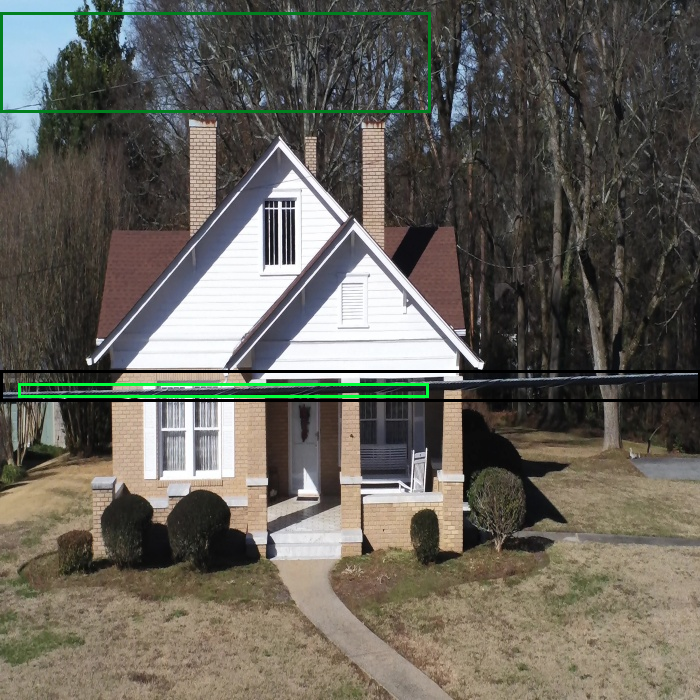

In [ ]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

THRESHOLD_SEGM = 0.5

#test_set = TTPLADataset('/content/drive/MyDrive/testset', '/content/drive/MyDrive/test.json')

model.eval()
#index_img = 1
index_img = np.random.randint(0,len(test_set)-1) #scelta randomica

img = test_set[index_img][0].to(device)
#img = (torchvision.io.read_image("img.jpg")/255).to(device)
pred = model([img])

#visualizzazione box
result = draw_bounding_boxes(image=torch.tensor((img*255),dtype=torch.uint8),boxes=pred[0]['boxes'],width=3)
torchvision.transforms.ToPILImage()(result)

<ipython-input-12-274e6b503b99>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = draw_segmentation_masks(image=torch.tensor((img*255),dtype=torch.uint8),masks=masks,alpha=0.5)


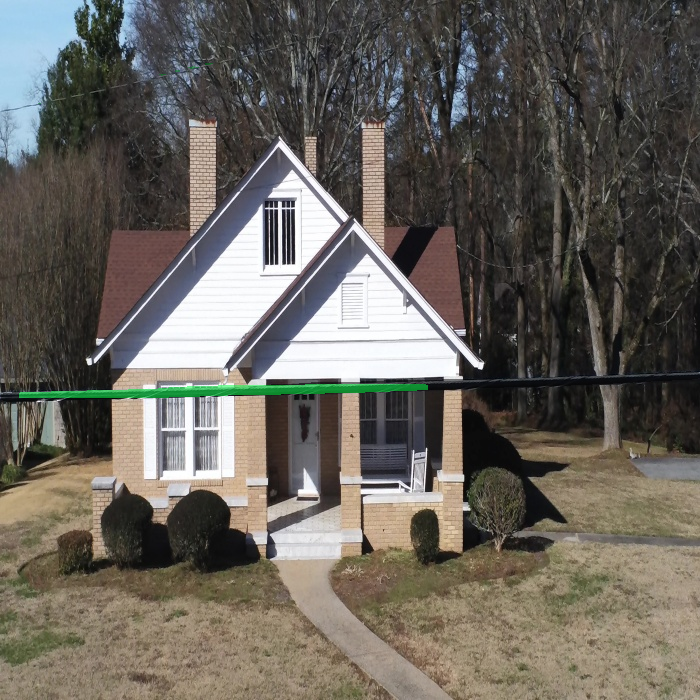

In [ ]:
#visualizzazione segmentazione
masks = torch.where(torch.squeeze(pred[0]['masks'])>0.5,True,False)
result = draw_segmentation_masks(image=torch.tensor((img*255),dtype=torch.uint8),masks=masks,alpha=0.5)
torchvision.transforms.ToPILImage()(result)

# Fase di testing

Proseguiamo con il notebook di testing per il modello addestrato. Il file prende ispirazione dal file di esempio caricato nella cartella del progetto dai docenti con qualche modifica per essere reso effetivamente fruibile per il testing

In [ ]:
test_set = TTPLADataset('/content/drive/MyDrive/testset', '/content/drive/MyDrive/test.json')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In questa fase viene predisposto il dataloader per il test set. Vengono effettuate le predizioni e vengono salvate in un file json sul drive. Questo file json sarà utile più avanti quando dovremo calcolare le metriche di nostro interesse come la mAP(50%) su box e segmentazione.

In [ ]:
THRESHOLD_SEGM = 0.5
model.eval()
batch_size = 1
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, collate_fn =lambda batch: tuple(zip(*batch)) )

results = []
for images, labels in test_dataloader:

  images = [image.to(device) for image in images]
  prediction = model(images)[0]
  classes = prediction['labels'].cpu().numpy()
  scores = prediction['scores'].cpu().detach().numpy()
  boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
  masks = torch.where(prediction['masks'].view(-1,700,700).cpu().detach()>THRESHOLD_SEGM,1,0).numpy()
  for i in range(masks.shape[0]): #per ogni oggetto identificato
    image_id = labels[0]['image_id']
    bbox = boxes[i]
    bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]
    bbox = [round(float(x)*10)/10 for x in bbox]
    rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('ascii')
    results.append({
                'image_id': int(image_id),
                'category_id': int(classes[i])-1,
                'bbox': bbox,
                'segmentation': rle,
                'score': float(scores[i]),
            })

  torch.cuda.empty_cache()
with open('/content/drive/MyDrive/pred.json', 'w') as fp: #salvataggio del json di predizione sul drive
    json.dump(results, fp)

Sfrutto adesso le funzioni messe a disposizione di *pycocotools* per il calcolo dei risultati.

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
test = '/content/drive/MyDrive/test.json'
pred = '/content/drive/MyDrive/pred.json'
gt = COCO(test)
detections = gt.loadRes(pred)

imgIds=sorted(gt.getImgIds())

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


In [ ]:
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [ ]:
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.72s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100